In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from datetime import datetime
from typing import Sequence
from torch.utils.data import random_split
#from d2l import torch as d2l
import matplotlib.pyplot as plt
import matplotlib.patches as patches


torch.manual_seed(123)



c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Project 2 - Object detection

## 2. Object Localization

In the first part, the task is to train a neural network to identify objects in an image, and then to outline the object with a bounding box. The images stem from a variation of part the MNIST such that there is only one (or zero) object(s) per image. After training a model we evaluate its performance, with accuracy as a measure. This works well on evaluating the object localization part, but does not give as much insight onto how well it predicts bounding boxes.  

In [2]:
train_data = torch.load("localization_train.pt") 
val_data = torch.load("localization_val.pt")
test_data= torch.load("localization_test.pt")



In [3]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    
    n_batch = len(train_loader)
    
    # We'll store there the training loss for each epoch
    losses_train = []
    
    # Set the network in training mode
    model.train()
    
    # Re-initialize gradients, just in case the model has been inappropriately 
    # manipulated before the training
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1): 
        
        # Training loss for the current epoch
        loss_train = 0
        


        # Loop over our dataset (in batches the data loader creates for us)
        for imgs, labels in train_loader:
            
            # Feed a batch into our model
            outputs = model(imgs)
            
            # Compute the loss we wish to minimize 
            # Note that by default, it is the mean loss that is computed
            # (so entire_batch_loss / batch_size)
            
            
            loss = loss_fn(labels, outputs)
        
            
            # Perform the backward step. That is, compute the gradients of all parameters we want the network to learn
            loss.backward()
            
            # Update the model
            optimizer.step() 
            
            # Zero out gradients before the next round (or the end of training)
            optimizer.zero_grad() 

            # Update loss for this epoch
            # It is important to transform the loss to a number with .item()
            loss_train += loss.item()
            
        # Store current epoch loss. 
        losses_train.append(loss_train / n_batch)
        

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
            
    return losses_train

In [4]:
class MNIST_model(nn.Module):
    """Model based on LeNet-5 CNN architecture"""
    def __init__(self):
        super().__init__()

        # 32*32*3: determined by our dataset: 32x32 RGB images
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features = 5*8*120 , out_features = 1000) # 5 is height 8 is width and 120 is nr channels.
        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100)
        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 +5) #C + 5 components
         
             

    def forward(self, x): 
        out = F.relu(self.conv1(x)) #F.relu is the activation function
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3(out))
        out = self.flat(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
        

In [5]:
def loss_fn(y_true, y_pred):
    """Function to compute the detection loss (L_A), the localization loss(L_B) and the classification loss(L_C) and then aggregate into a single loss value (L_loc)"""
    LA = nn.BCEWithLogitsLoss(reduction='none')
    A = LA(y_pred[:,0], y_true[:,0])
        
    LB = nn.MSELoss(reduction='none')
    B = torch.sum(LB(y_pred[:,1:5], y_true[:,1:5]), dim = 1)
    LC = nn.CrossEntropyLoss(reduction='none')
    C = LC(y_pred[:,5:], y_true[:,5].long())
        
        
    L_loc = torch.where(y_true[:,0] == 1, A+B+C, A)
    L_loc = torch.mean(L_loc)
    
    return L_loc
        
        
        

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

#debug_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(val_data, range(100)), batch_size=128, shuffle=False)

In [7]:
torch.manual_seed(123)
model = MNIST_model()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

optimizer = optim.SGD(model.parameters(), lr=1e-2) #lr=1e-2 is the same as lr=0.01

loss_train = train(1, optimizer, model, loss_fn, train_loader)
loss_train

23:32:10.468146  |  Epoch 1  |  Training loss 2.513


[2.5132665562373337]

In [8]:
def compute_iou(bb1, bb2):
    A_x0 = bb1[:,0] - bb1[:,2]/2
    A_y0 = bb1[:,1] - bb1[:,3]/2
    A_x1 = bb1[:,0] + bb1[:,2]/2
    A_y1 = bb1[:,1] + bb1[:,3]/2
    
    B_x0 = bb2[:,0] - bb2[:,2]/2
    B_y0 = bb2[:,1] - bb2[:,3]/2
    B_x1 = bb2[:,0] + bb2[:,2]/2
    B_y1 = bb2[:,1] + bb2[:,3]/2
    
    #compare each element of the tensors between A and B
    
    I_x0 = torch.max(A_x0,B_x0)
    I_y0 = torch.max(A_y0,B_y0)
    I_x1 = torch.min(A_x1,B_x1)
    I_y1 = torch.min(A_y1,B_y1)
    
    I_area = (I_x1 - I_x0)*(I_y1 - I_y0)
    
    A_area = (A_x1 - A_x0)*(A_y1 - A_y0)
    B_area = (B_x1 - B_x0)*(B_y1 - B_y0)
    
    U_area = A_area + B_area - I_area
    
    IoU = I_area / U_area
    
    return IoU
    
    
    
    
    
     

In [15]:
def plot_boundingbox(bb1, bb2, img):
    batch_size = img.shape[0]

    for b in range(0, batch_size, 100):
        fig, ax = plt.subplots()

        A_x = bb1[b, 0] - bb1[b, 2] / 2
        A_y = bb1[b, 1] - bb1[b, 3] / 2

        B_x = bb2[b, 0] - bb2[b, 2] / 2
        B_y = bb2[b, 1] - bb2[b, 3] / 2

        box1 = patches.Rectangle((A_x, A_y), bb1[b, 2], bb1[b, 3], linewidth=2, edgecolor="r")
        box2 = patches.Rectangle((B_x, B_y), bb2[b, 2], bb2[b, 3], linewidth=2, edgecolor="g")

        ax.imshow(img[b].squeeze(0))

        ax.add_patch(box1)
        ax.add_patch(box2)

        plt.show()


In [19]:
def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    tot_iou = 0
    totalpc1 = 0
    
    totalpcright = 0

    # We do not want gradients here, as we will not want to update the parameters.
    with torch.no_grad():
        for imgs, labels in loader:

            outputs = model(imgs)
            
            
            """
            if labels[0] == 0:
                if outputs[0] == 0:
                    correct += 1
            else:
                if outputs[0] == 0:
                    continue
                else:
                    if argmax(outputs[6:16]) == label[6]
                        correct += 1
                total_iou = iou(output[1:5], label[1:5]) 
                
                correct/ba
            
            """
            
            
            pc1 = torch.where(labels[:,0] == 1)[0]
            #print(pc1)
            
            
            _, predicted = torch.max(outputs[:,5:], dim=1) 
            predicted = torch.unsqueeze(predicted, 1)
            #print(labels.shape[0])
            total += labels.shape[0]
            totalpc1 += pc1.shape[0]
            correct += int((predicted[pc1] == labels[pc1,5:]).sum())
        
            
            #print(f"{outputs[:,1:5].shape} {labels[:,1:5].shape}")
        
            
            plot_boundingbox(outputs[pc1,1:5], labels[pc1,1:5], imgs[0])
            iou = compute_iou(outputs[pc1,1:5], labels[pc1,1:5])
            
            #correctpc = ((torch.sigmoid(predicted[:,0]) < 0.5) && (labels[:,0] == 0))[]
            #totalpcright += correctpc.shape[0]
            
            #print(total.shape[0])
            

    accpc = totalpcright/total
    print(accpc)

    acc =  ((correct / total) + (iou/totalpc1))/2

    #print(acc.shape)

    #print("Accuracy: {:.2f}".format(sum(acc)/acc.shape[0]))
          
    return acc
    

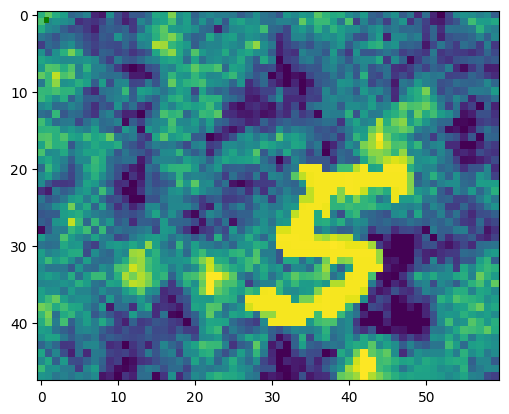

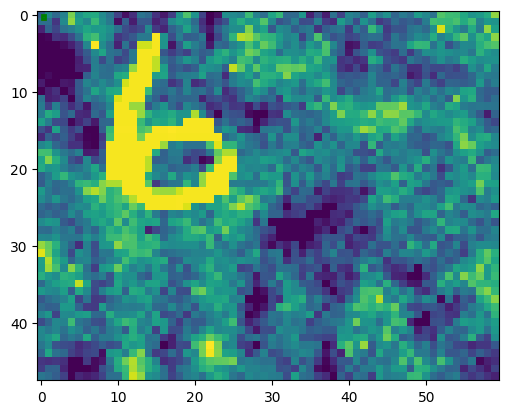

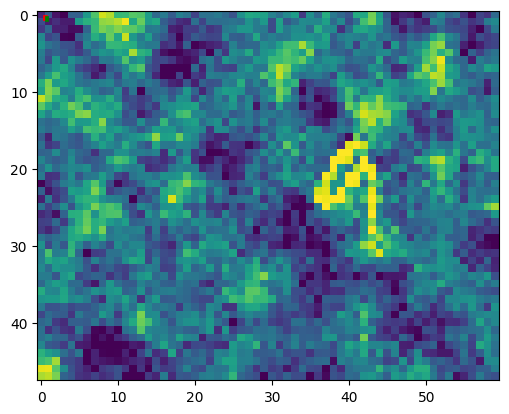

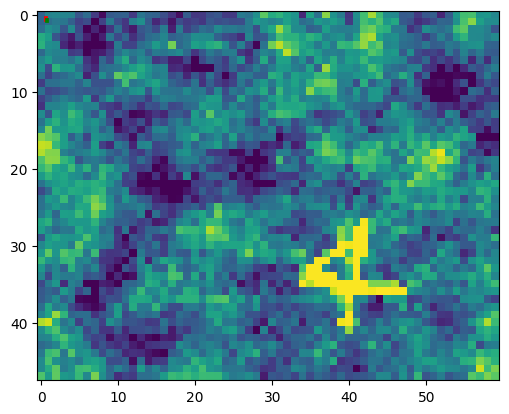

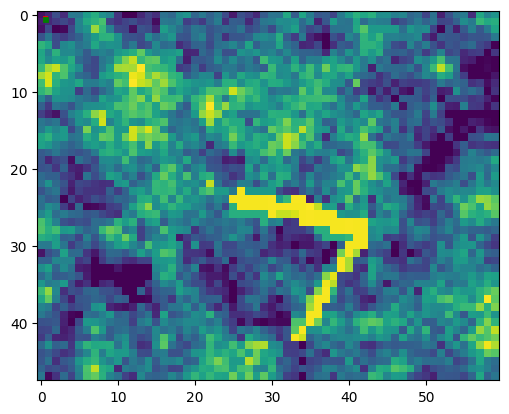

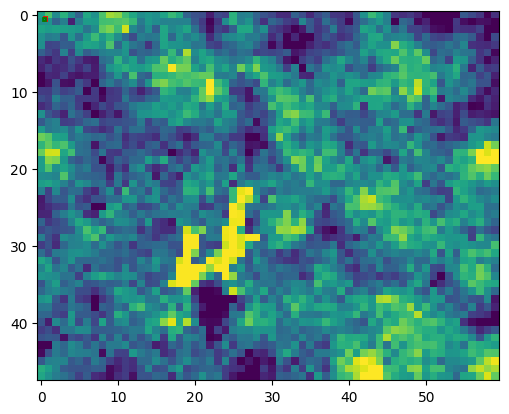

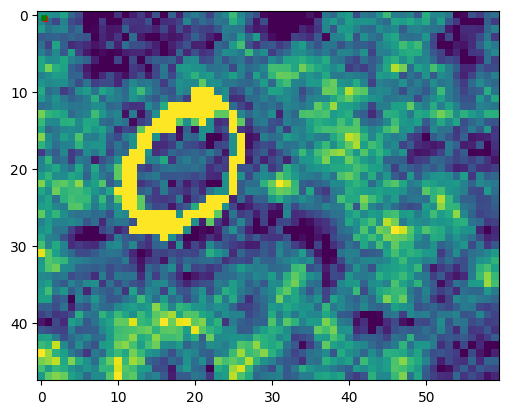

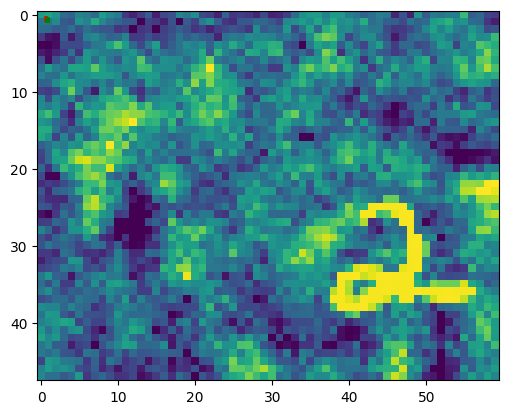

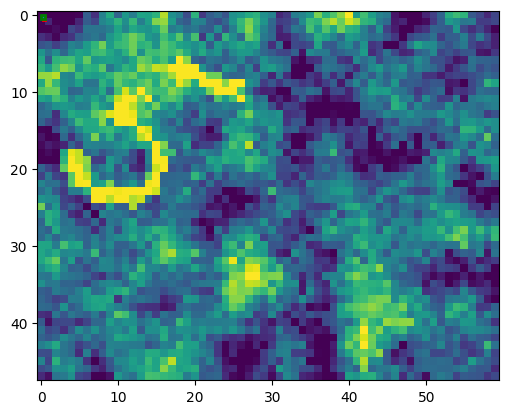

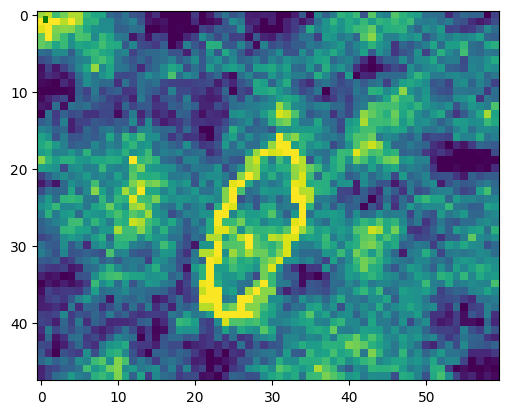

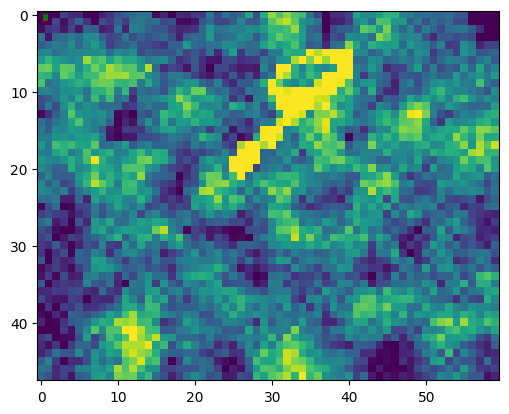

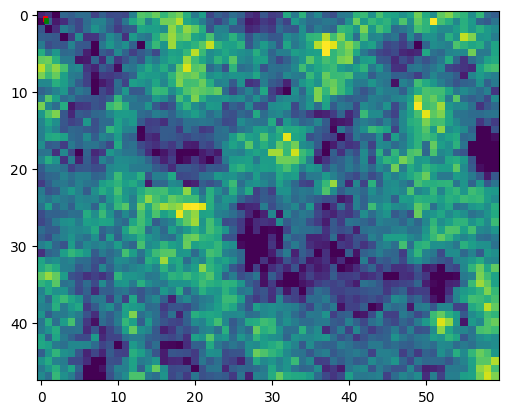

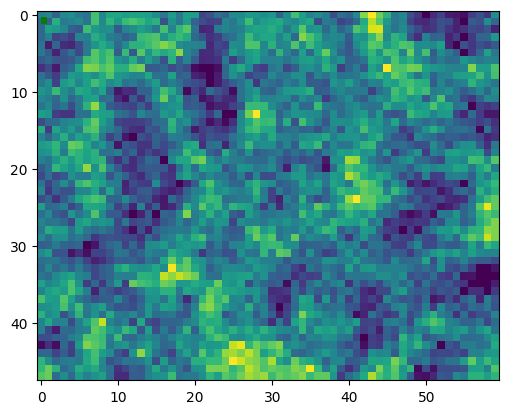

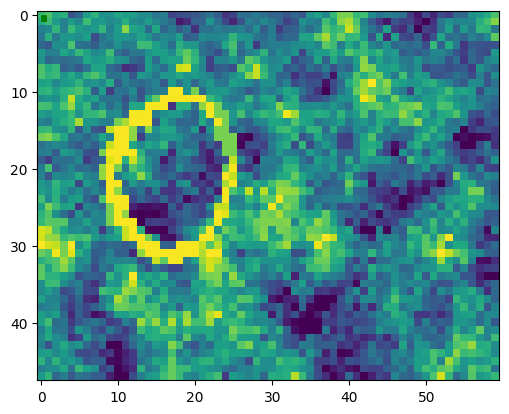

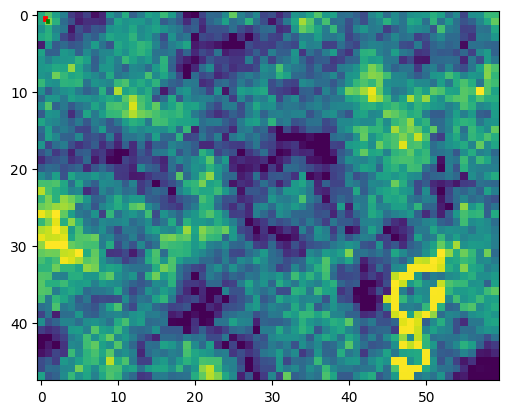

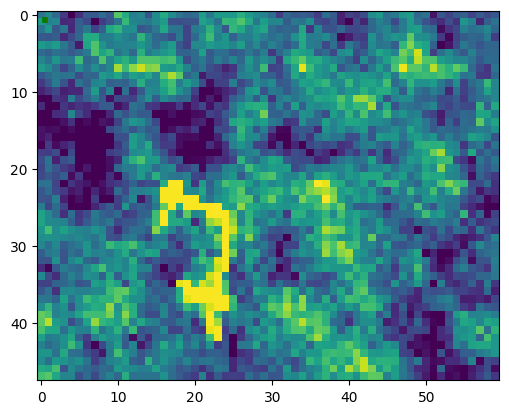

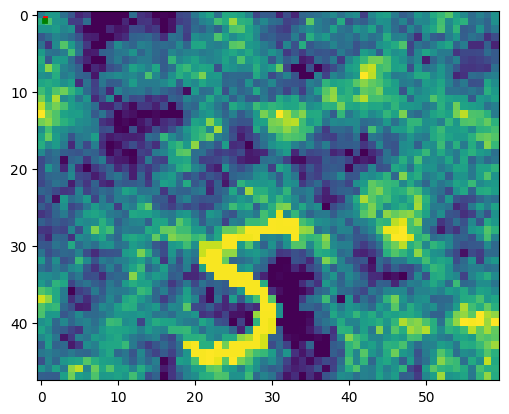

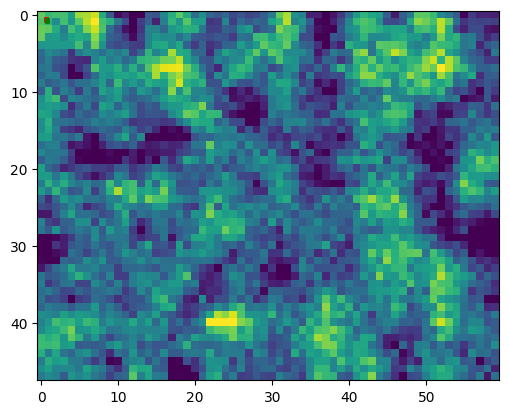

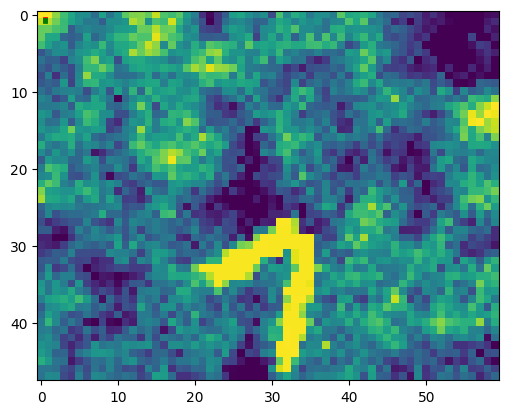

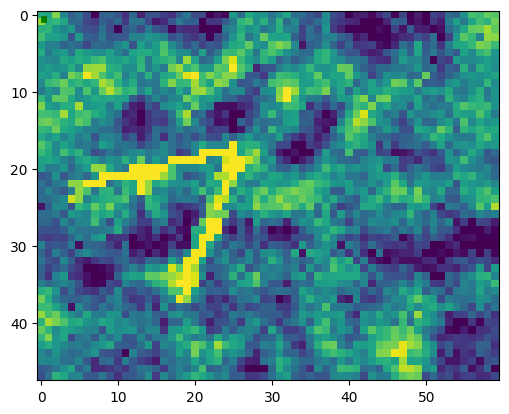

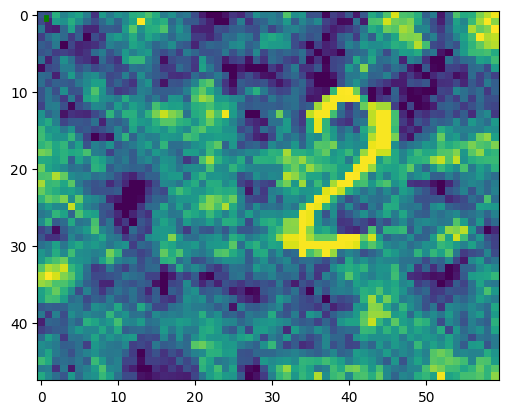

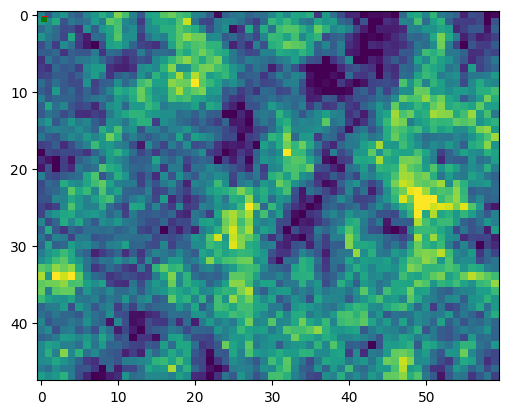

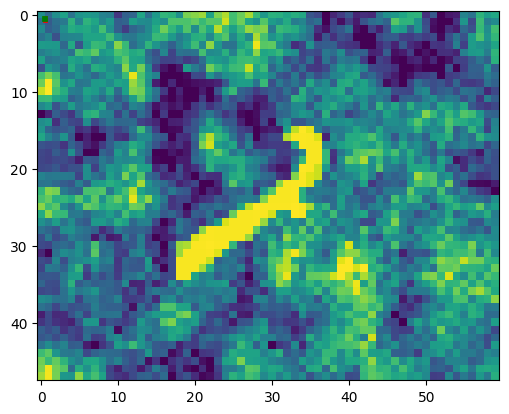

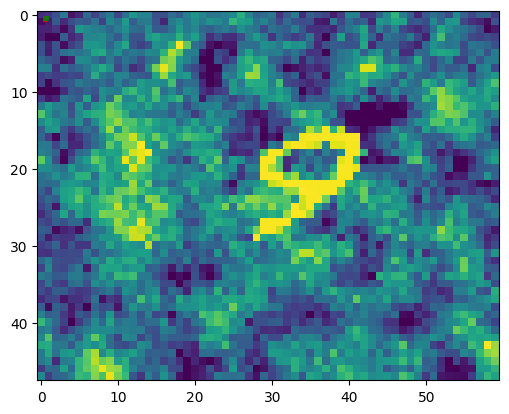

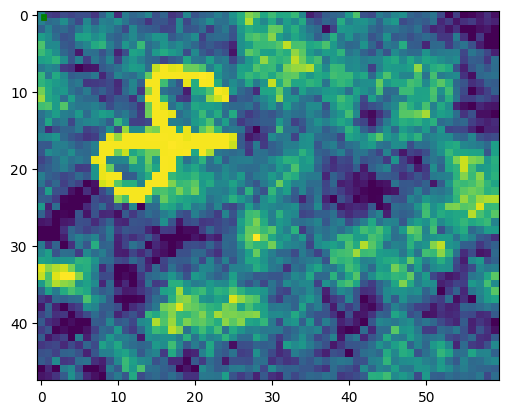

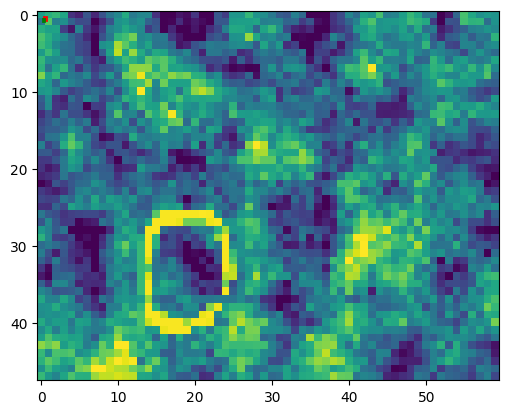

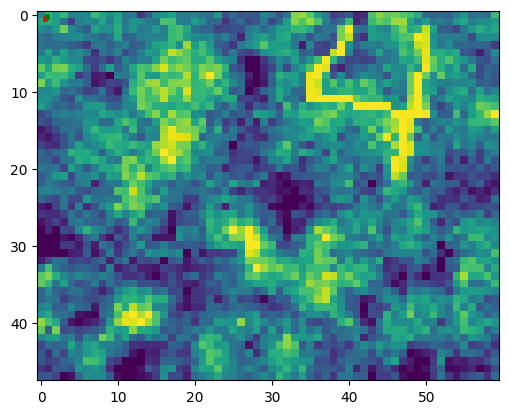

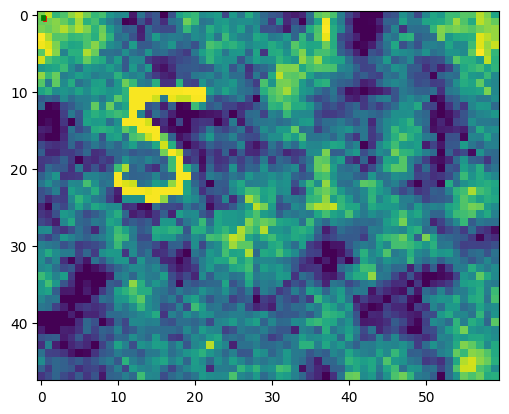

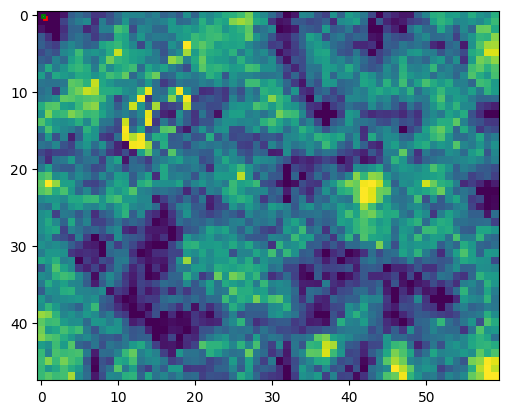

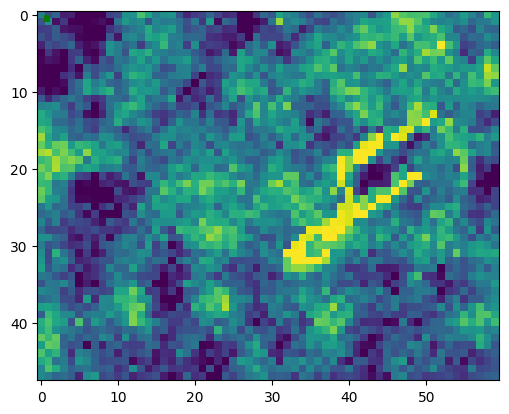

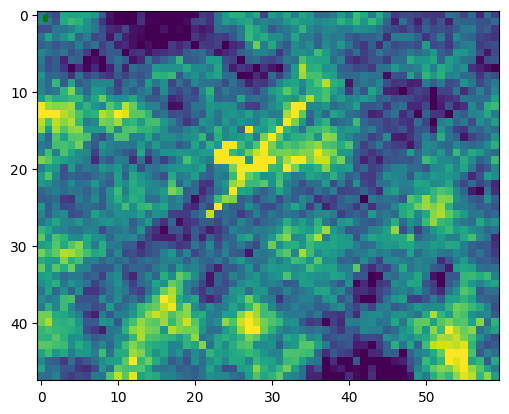

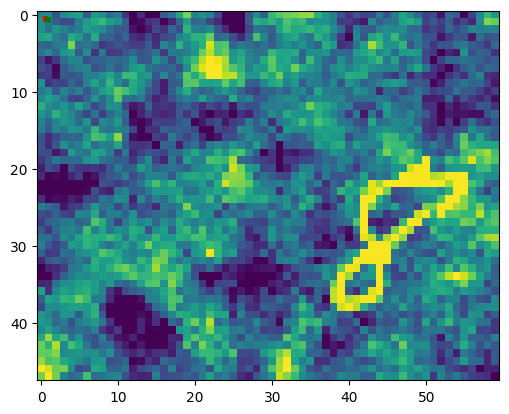

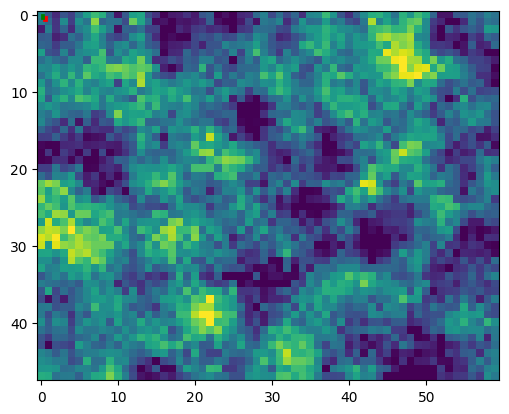

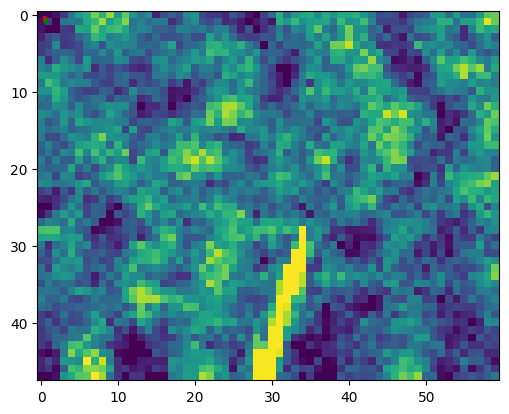

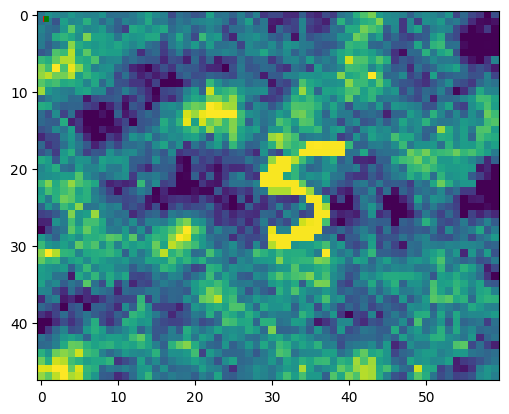

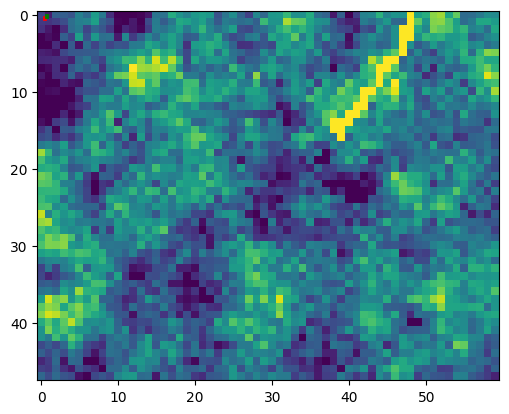

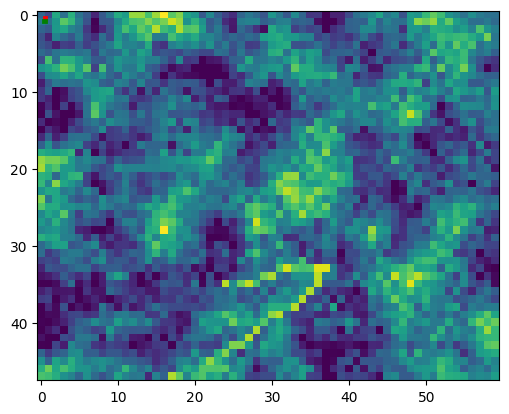

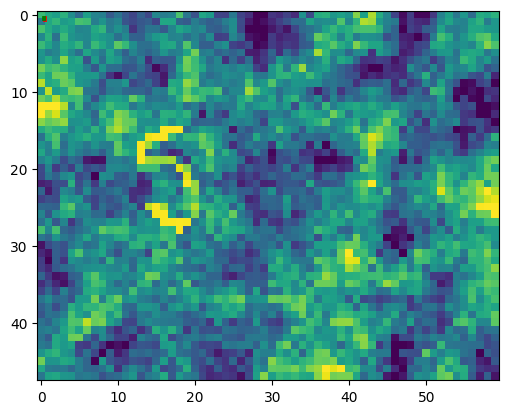

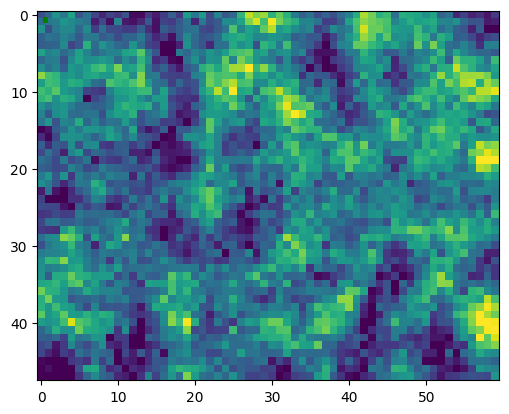

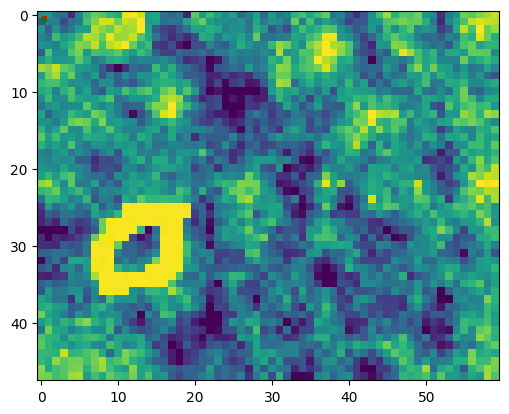

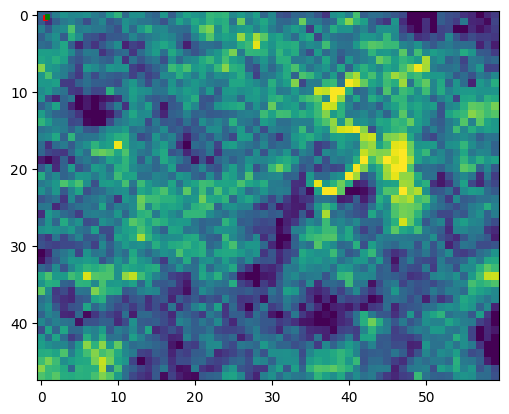

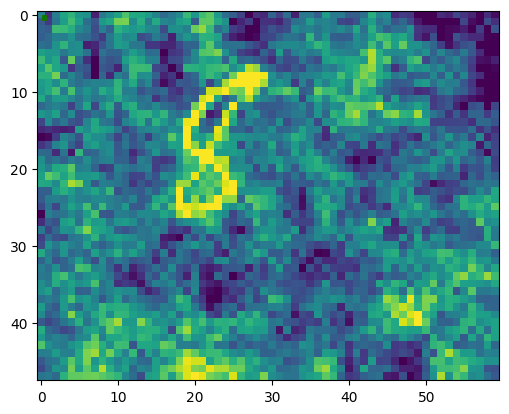

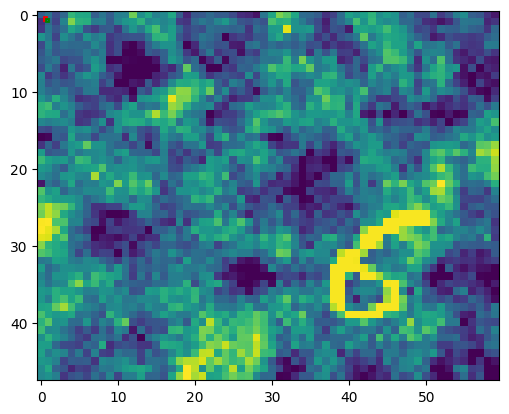

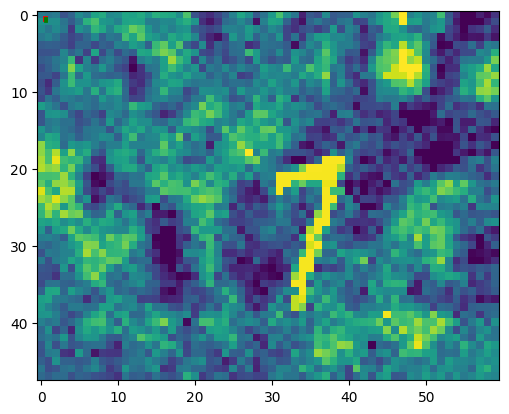

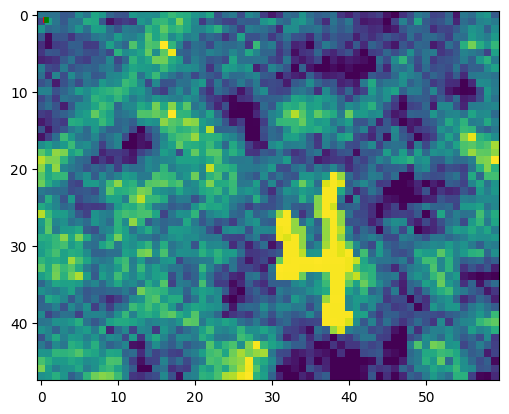

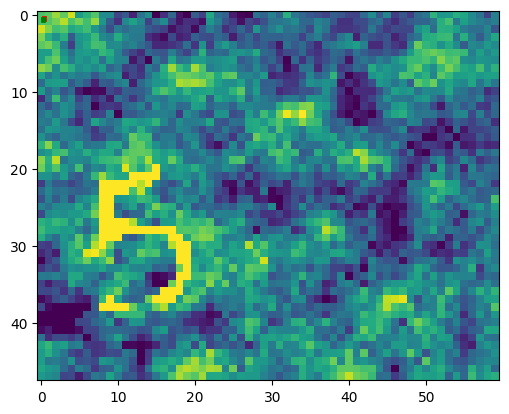

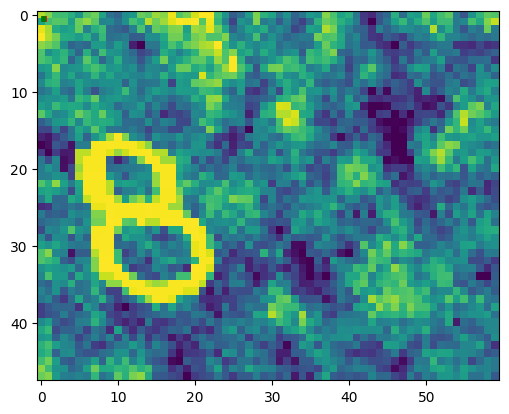

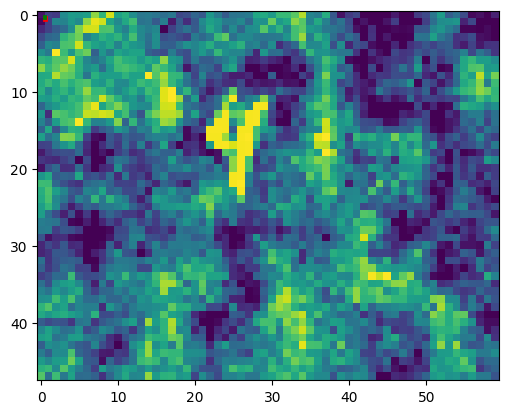

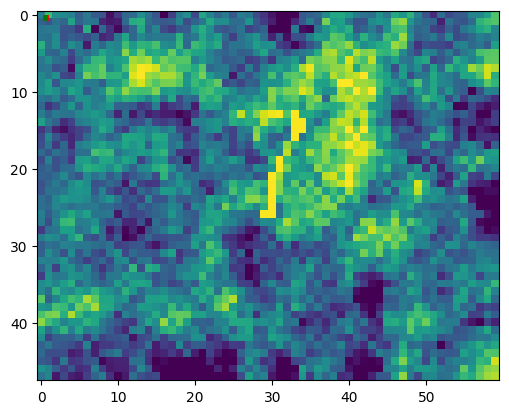

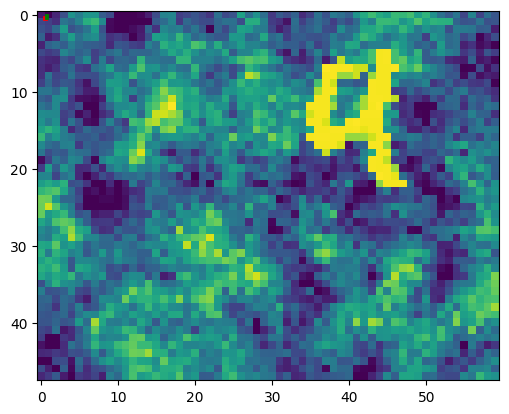

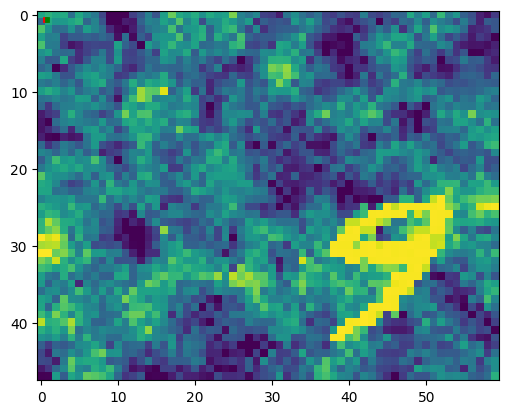

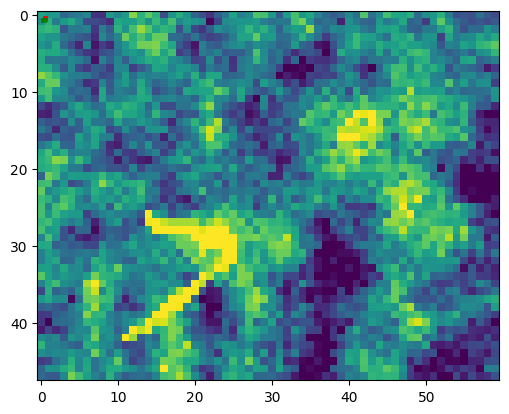

0.0


tensor([0.0474, 0.0473, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0473, 0.0474,
        0.0474, 0.0473, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0473, 0.0474, 0.0473, 0.0474, 0.0474, 0.0473, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0473, 0.0474, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0473, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0474, 0.0474])

In [20]:
torch.manual_seed(123)


compute_accuracy(model, val_loader)


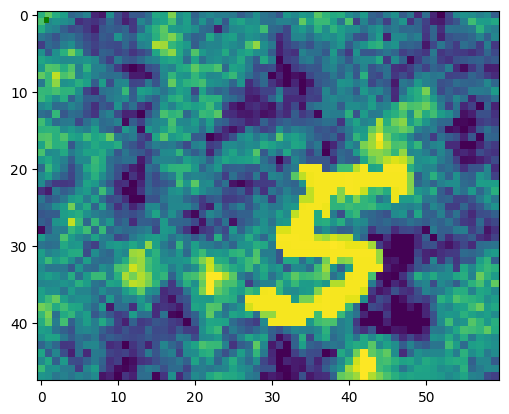

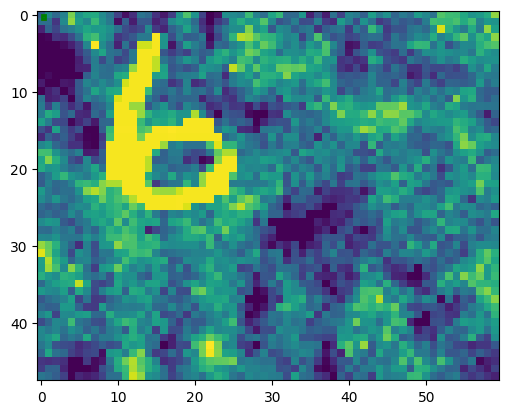

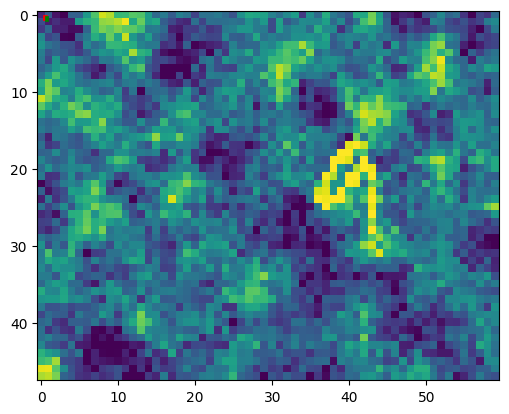

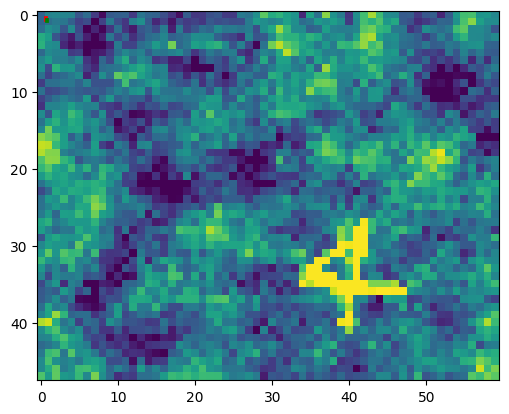

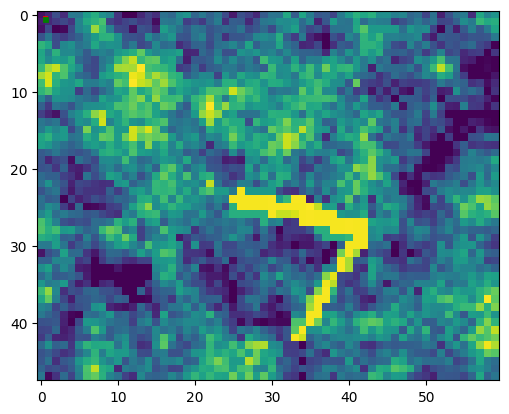

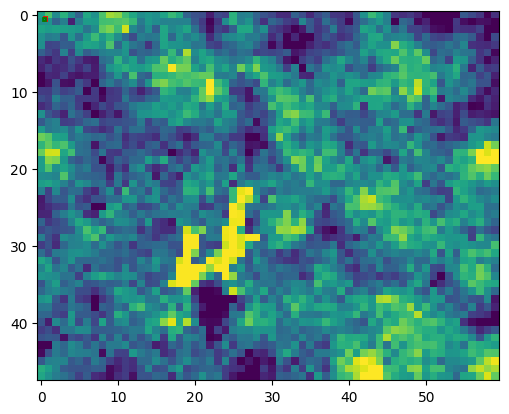

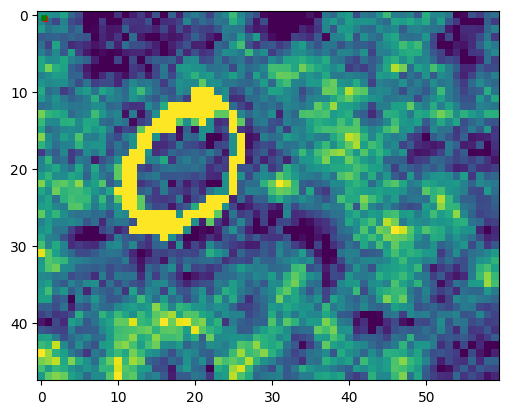

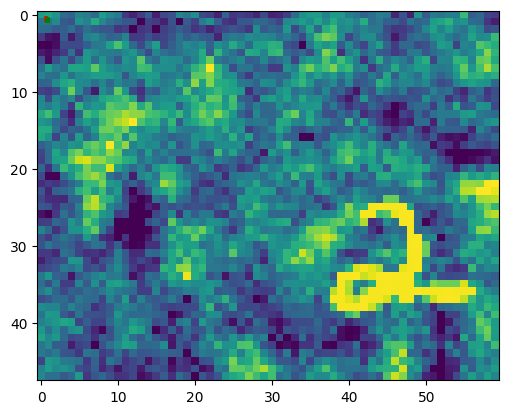

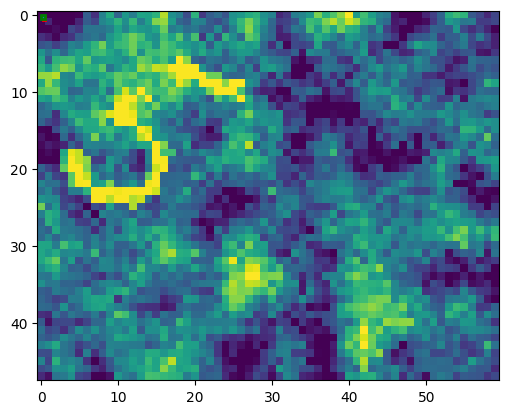

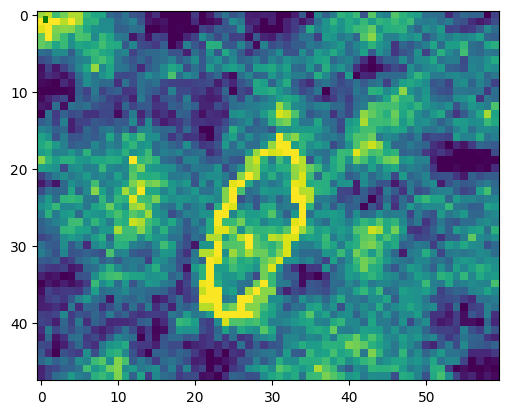

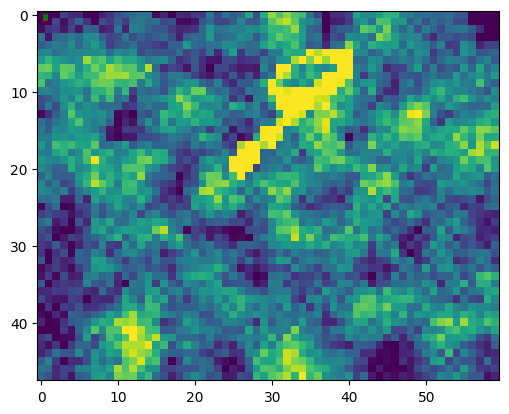

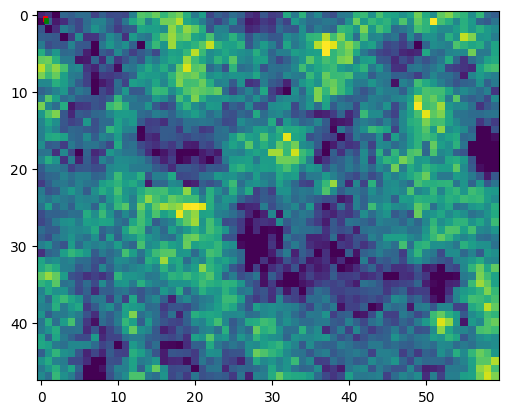

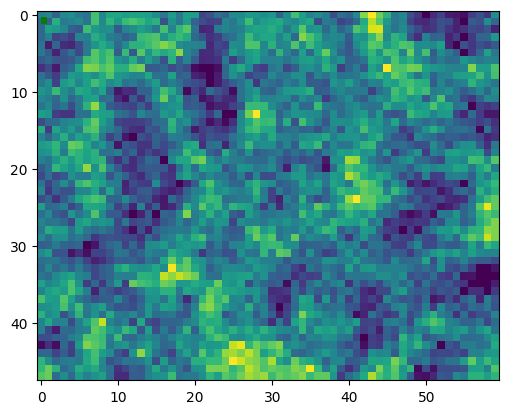

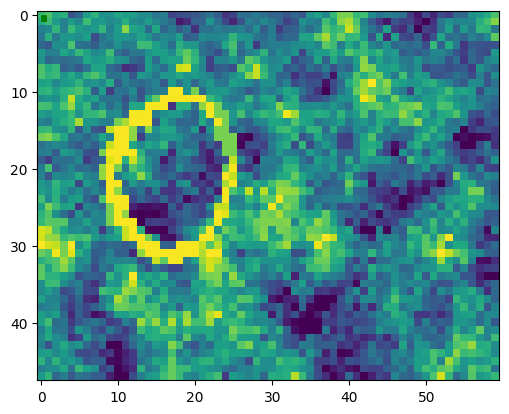

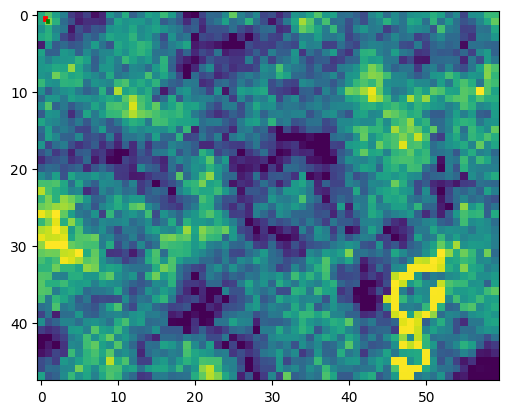

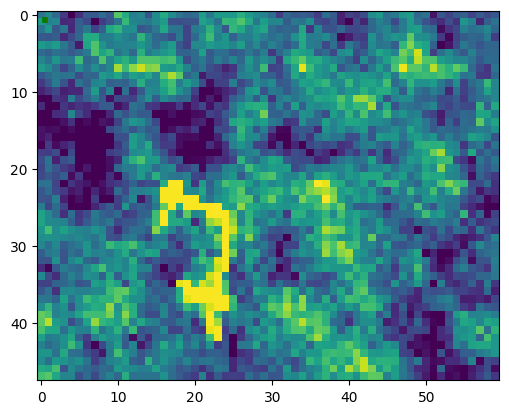

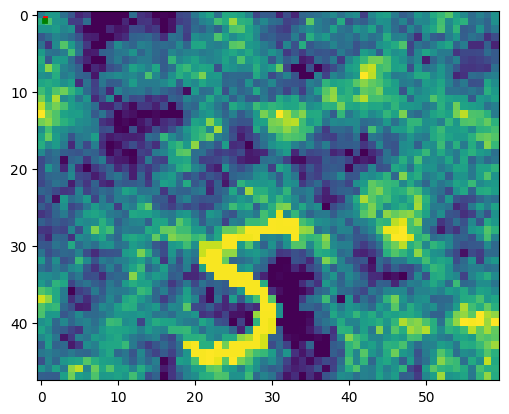

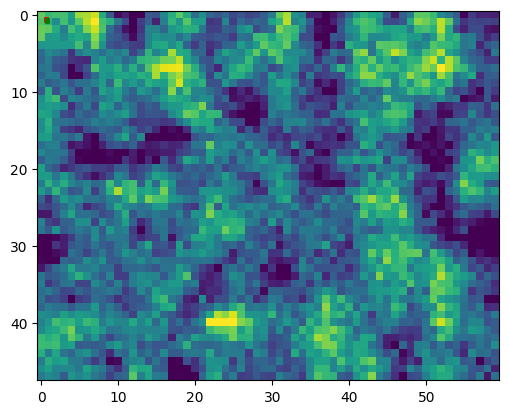

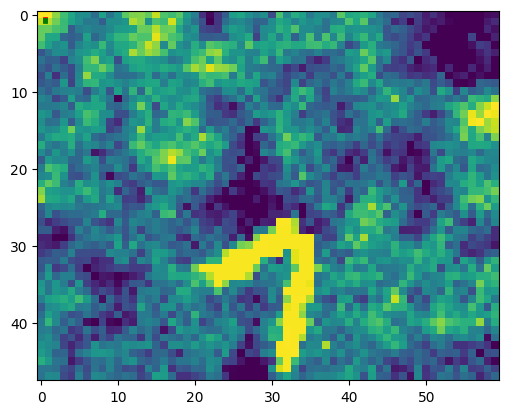

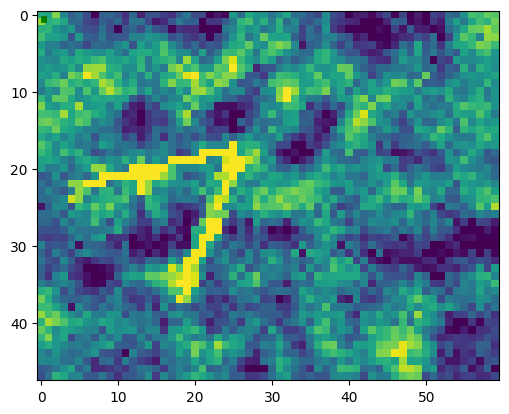

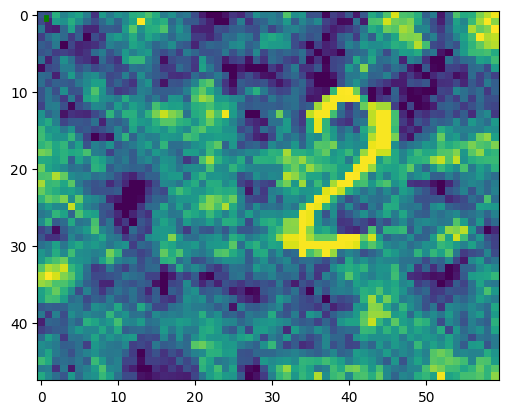

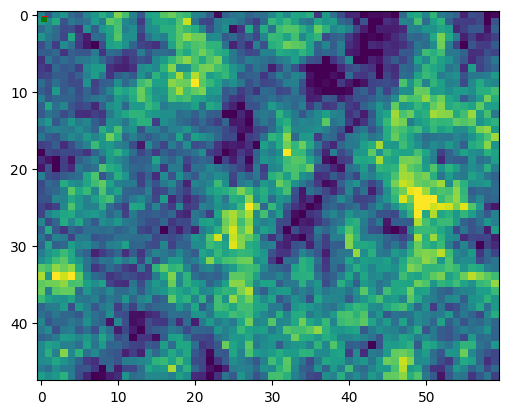

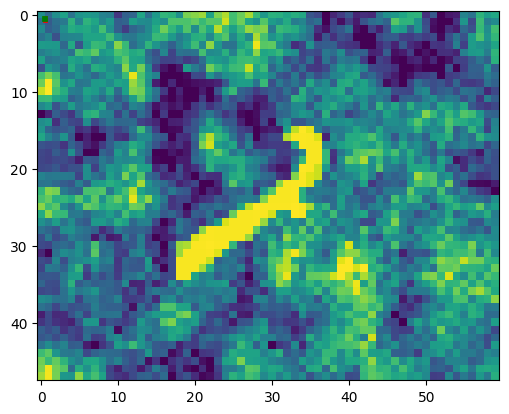

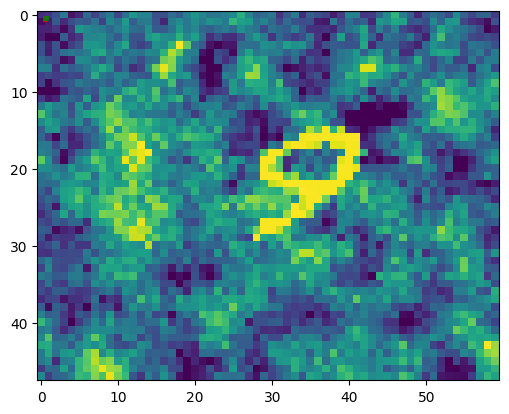

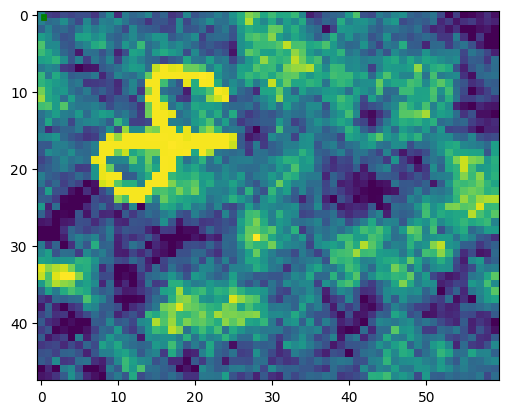

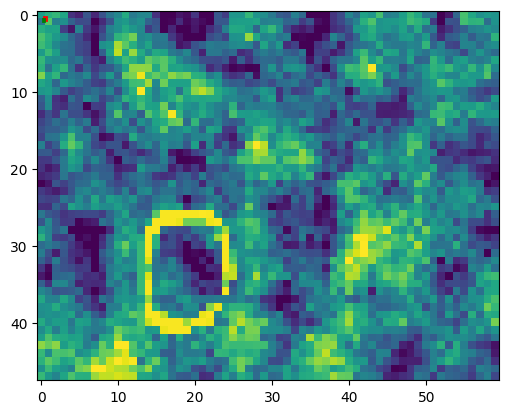

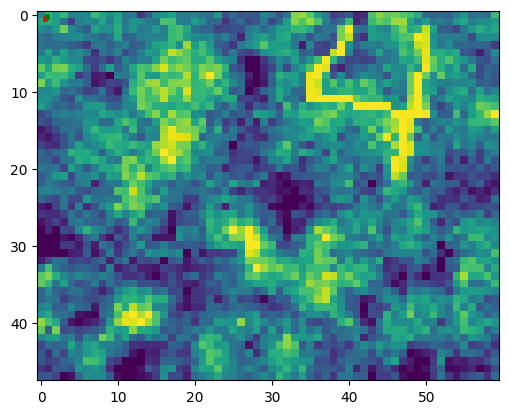

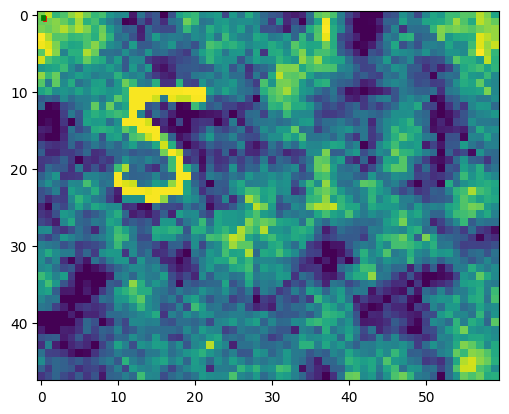

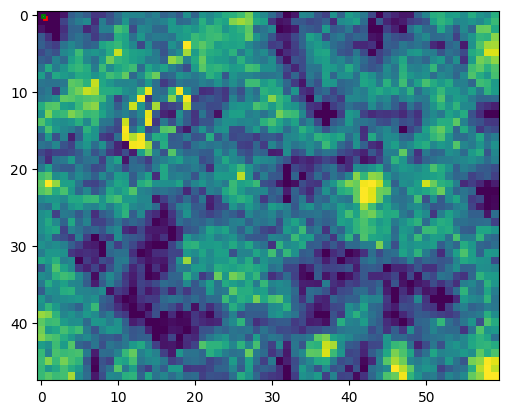

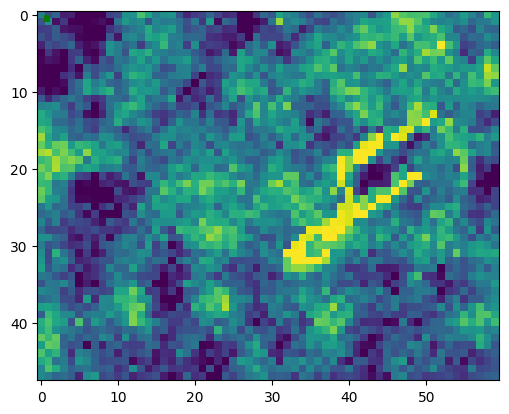

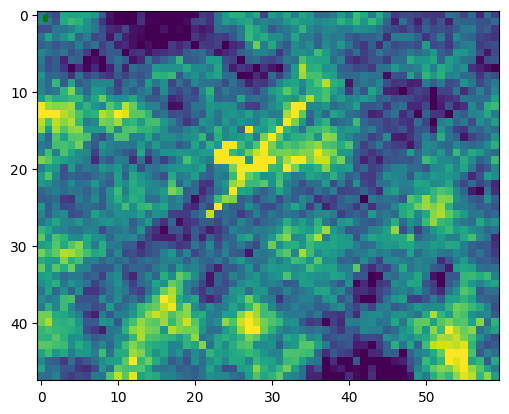

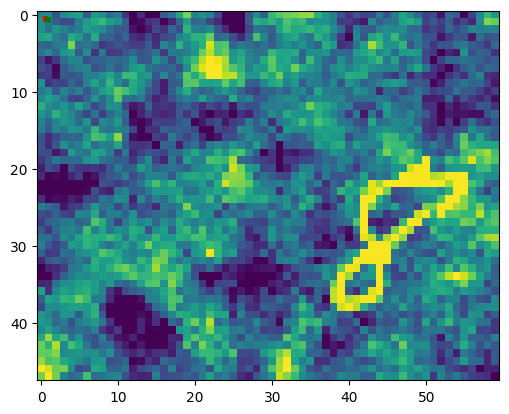

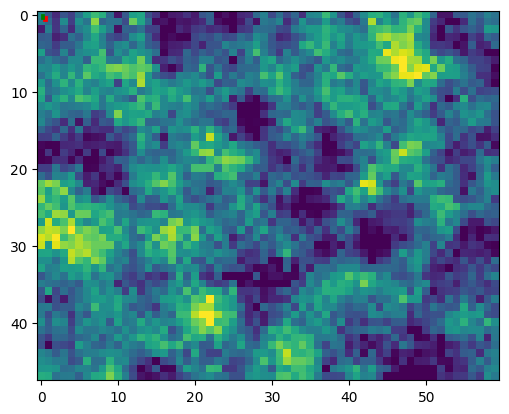

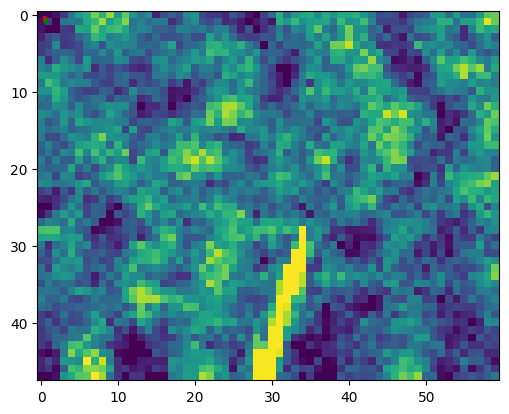

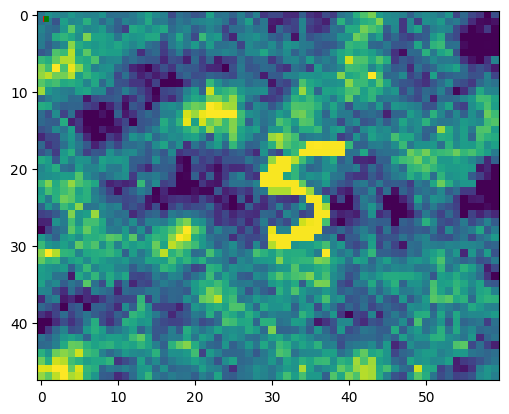

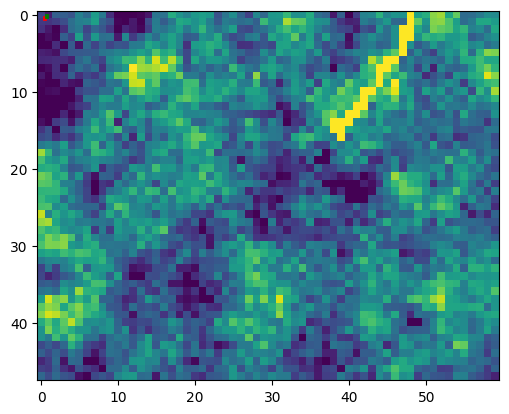

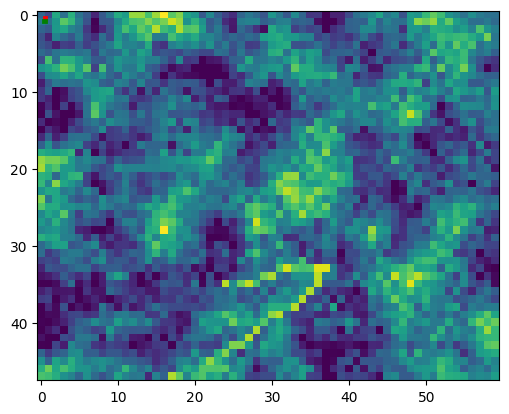

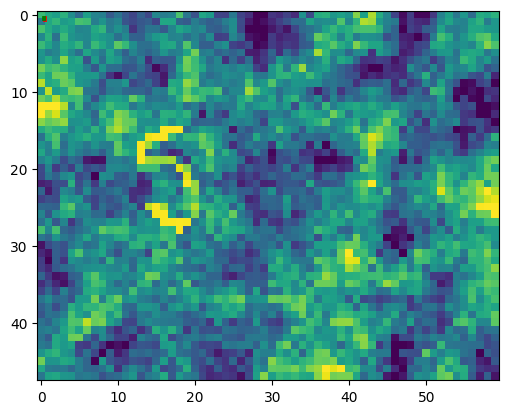

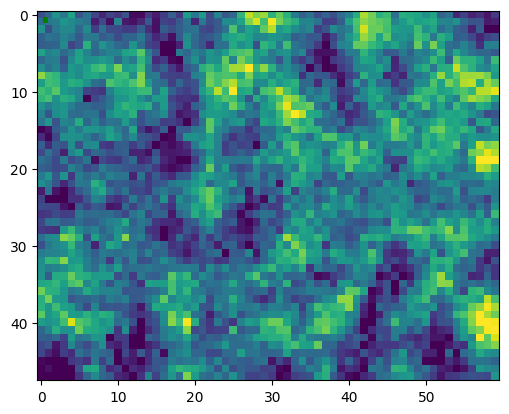

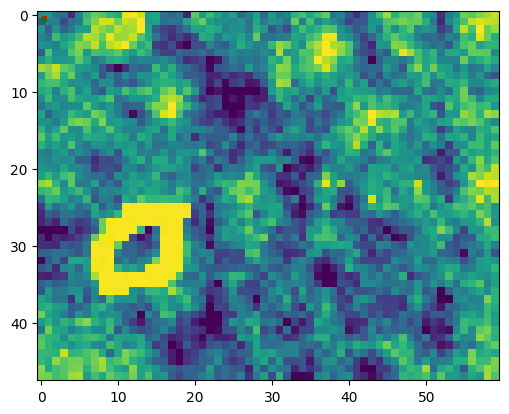

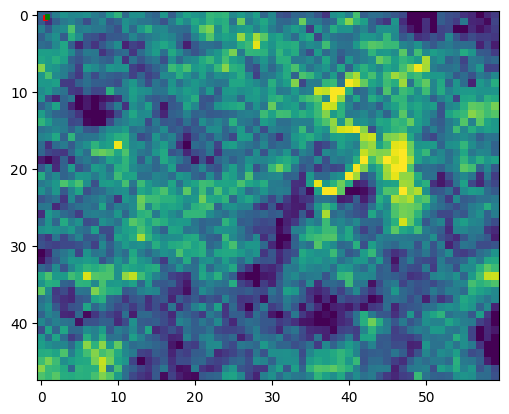

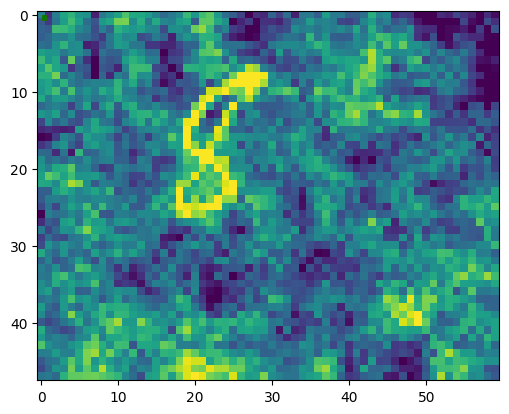

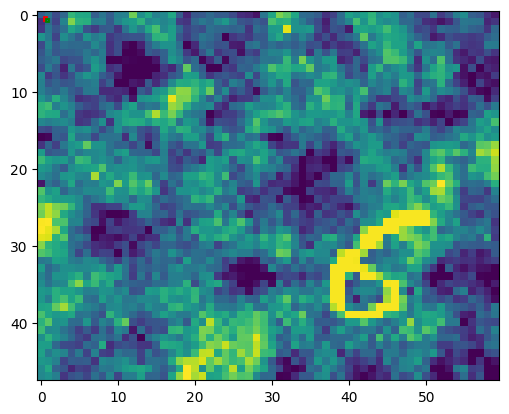

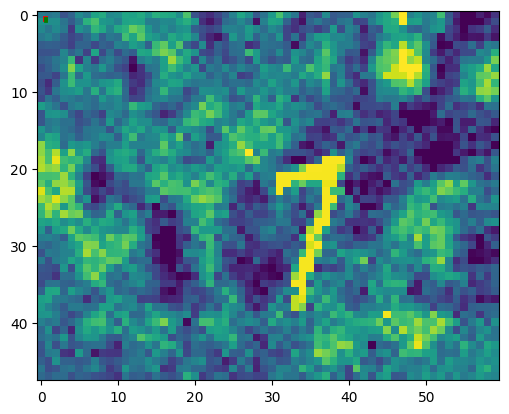

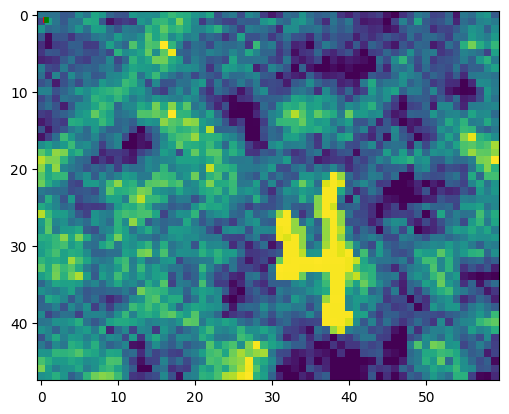

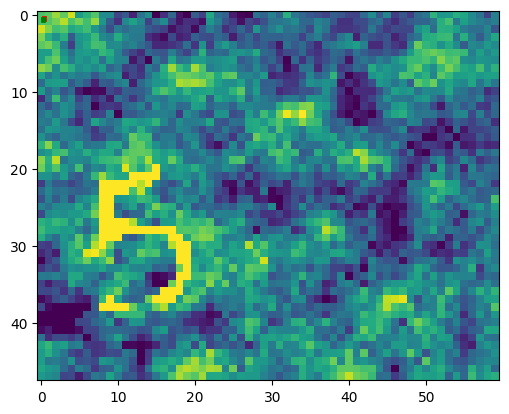

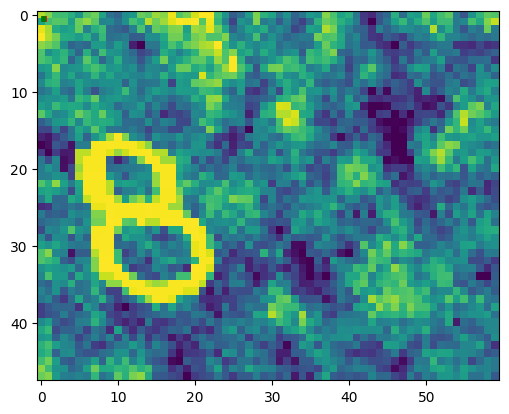

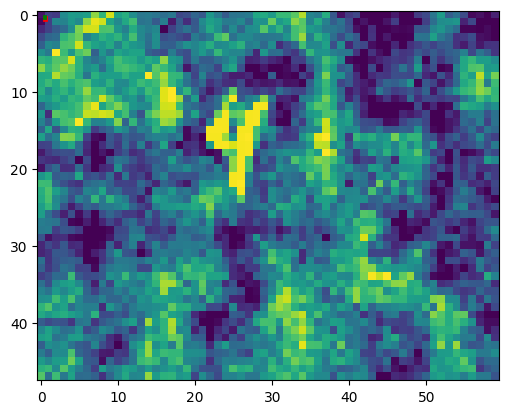

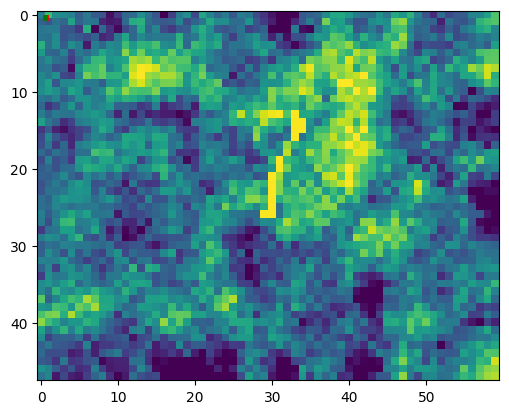

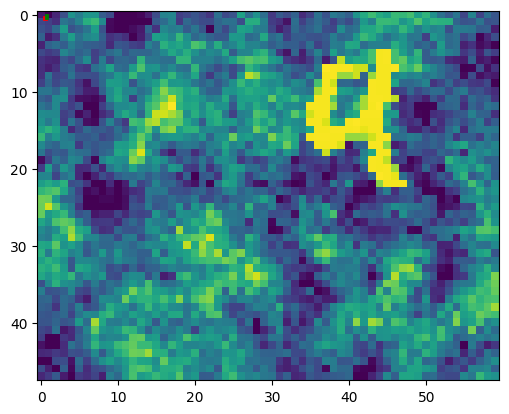

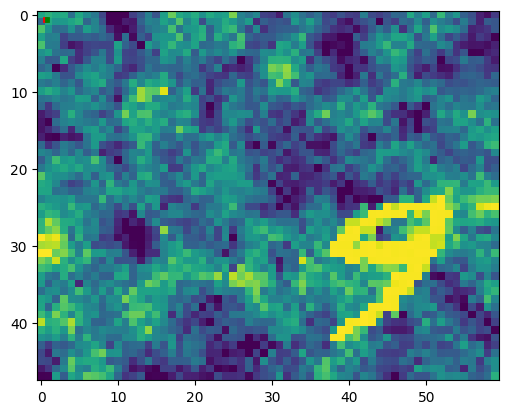

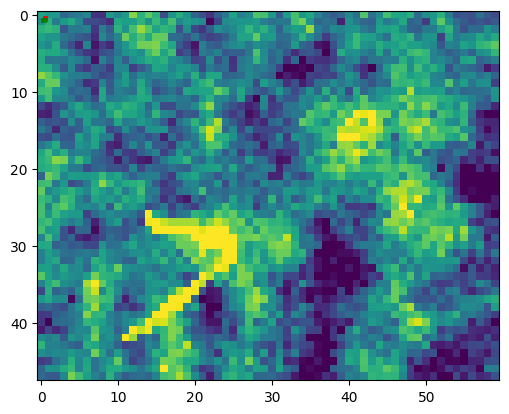

0.0


tensor([0.0474, 0.0473, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0473, 0.0474,
        0.0474, 0.0473, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0473, 0.0474, 0.0473, 0.0474, 0.0474, 0.0473, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0473, 0.0474, 0.0473, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0473, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.0474,
        0.0474, 0.0474, 0.0474, 0.0474, 0.0474])

In [21]:
compute_accuracy(model, val_loader)


# Object detection

In [ ]:
detection_train_data = torch.load("list_y_true_train.pt") 
detection_val_data = torch.load("list_y_true_val.pt")
detection_test_data= torch.load("list_y_true_test.pt")

In [ ]:
class MNIST_model_detection(nn.Module):
    def __init__(self):
        super().__init__()  # to inherit the '__init__' method from the 'nn.Module' class
        # Add whatever you want here (e.g layers and activation functions)
        # The order and names don't matter here but it is easier to understand
        # if you go for Layer1, fun1, layer2, fun2, etc
        # Some conventions:
        # - conv stands for convolution
        # - pool for pooling
        # - fc for fully connected

        # 32*32*3: determined by our dataset: 32x32 RGB images
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features = 5*8*120 , out_features = 1000) # 5 is height 8 is width and 120 is nr channels.
        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100)
        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 +5) #C + 5 components
         
        
             

    def forward(self, x):
        # Now the order matters! 
        out = F.relu(self.conv1(x)) #F.relu is the activation function
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3(out))
        out = self.flat(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out